In [47]:
#imorting libraries
from pybtex.database.input import bibtex
import pandas as pd
import re
import os
from datetime import datetime
from collections import defaultdict
from io import StringIO
from nltk import tokenize
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from pprint import pprint
import csv
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim (optional)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from','edu', 'use', 'research'])

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import jaccard_score


DEBUG = False # If True: debug
ADJ_MATRIX = False #If True draw Adjacency Matrix after any change in the corpus
WRITE = False#If true files
PLOTING = False
CHECK = False

original_doc_count = 0 
original_word_count = 0

In [48]:
#FUNCTIONS

#Draw Adjacancy Matrix 
def draw_adj_matrix(data_list):
    global original_doc_count 
    global original_word_count
    data = data_list
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data)
    Xcsr=X.tocsr()
    doc_term_matrix = X.todense()
    dtm_df = pd.DataFrame(doc_term_matrix, columns=vectorizer.get_feature_names())
    #Xcsr = Xcsr[0:100, 0:100]
    print("Matrix Shape")
    print(Xcsr.shape)

    a = dtm_df.to_numpy()
    for i in range(Xcsr.shape[0]):
        for j in range(Xcsr.shape[1]):
            if a[i,j] > 0:
                a[i,j] = 1
                if i>1 and j>1:
                    a[i-1,j-1] = 1
                    a[i-1,j-2] = 1

    if Xcsr.shape[0] > original_doc_count: original_doc_count = Xcsr.shape[0]
    if Xcsr.shape[1] > original_word_count: original_word_count = Xcsr.shape[1]
    b = np.zeros(shape=(original_doc_count,original_word_count))   

    for i in range(Xcsr.shape[0]):
        for j in range(Xcsr.shape[1]):
            b[i,j] = a[i,j]
    a = b

    # Fixing random state for reproducibility
    fig, ax = plt.subplots()
    image = a
    ax.imshow(image, cmap='binary', interpolation='nearest', aspect='auto')
    ax.set_title('dropped spines')

    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 0))
    ax.spines['bottom'].set_position(('outward', 0))
    # Hide the right and top spines
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')

    plt.show()


#Simple Pre-processing
def simple_preprocessing(d):
    data = d
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', ' ', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", " ", sent) for sent in data]
    data = [re.sub("\n", " ", sent) for sent in data]
    data = [re.sub("œ", " ", sent) for sent in data]
    data = [re.sub("â", " ", sent) for sent in data]
    data = [re.sub("\200", " ", sent) for sent in data]
    data = [re.sub("\235", " ", sent) for sent in data]
    data = [re.sub("\231s", " ", sent) for sent in data]

    #To lowercase
    data = [d.lower() for d in data]
    
    return data


#Replace Text in a Document
def multiple_replace(dict, text):
    # Creating a regular expression  from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))
    
    # Editing based on dictionary
    d = 0
    for t in text:
        text[d] = regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], t) 
        d += 1
    return text


#show Bigrams and -grams
def show_ngrams(data, min_count, threshold_2, threshold_3):
    # Build bigram and trigram models
    threshold = threshold_2
    bigram = gensim.models.Phrases(data_words, min_count=2, threshold=1) # higher threshold fewer phrases.
    threshold = threshold_3
    trigram = gensim.models.Phrases(bigram[data_words], min_count=2, threshold=1)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    if(DEBUG):
        print("//////////  trigrams example:  ////////")
        print(trigram_mod[bigram_mod[data_words[0]]])

    #Show Bigrams
    b = 0 
    show_bigrams = []
    new_set  =bigram_mod[data_words]
    for doc in new_set:
        for w in doc:
            if ('_' in w):
                b+=1
                show_bigrams.append(w)
    show_bigrams_dict = {i:(show_bigrams.count(i)+1) for i in show_bigrams} 
    show_bigrams_dict_sorted = {k: v for k, v in sorted(show_bigrams_dict.items(), key=lambda item: item[1])}

    keys_bigrams = []
    for key in show_bigrams_dict_sorted:
        keys_bigrams.append(key)


    #Show Trigrams
    t = 0 
    show_trigrams = []
    new_set  =trigram_mod[bigram_mod[data_words]]
    for doc in new_set:
        for w in doc:
            if w.count("_") > 1:
                t+=1
                show_trigrams.append(w)
    show_trigrams_dict = {i:(show_trigrams.count(i)+1) for i in show_trigrams} 
    show_trigrams_dict_sorted = {k: v for k, v in sorted(show_trigrams_dict.items(), key=lambda item: item[1])}
    keys_trigrams = []
    for key in show_trigrams_dict_sorted:
        keys_trigrams.append(key)
        
    return show_bigrams_dict_sorted, show_trigrams_dict_sorted

def simple_plot(title, terms , values, Xlabel, Ylabel):
    plt.plot(terms, values)
    plt.title(str(title))
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    plt.show()
    
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=3, max_len= 40))  # deacc=True removes punctuations

        #functions for stopwords, and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]
    #return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [49]:
#read data from .bib and .csv files - Multiple .bib files for each scintific database or one .csv file for each database
bib_files = ["D:/CTA/1- acm - evalu (1).bib",
             "D:/CTA/2- acm - evalu (2).bib",
             "D:/CTA/3- acm - assess (1).bib",
             "D:/CTA/4- acm - measur (1).bib",
             "D:/CTA/5- acm - m & E (1).bib",
             "D:/CTA/6- acm - A & E (1).bib",
             "D:/CTA/7- acm - A & M (1).bib",
             "D:/CTA/8- acm A & M & E (1).bib",
             "D:/CTA/1- IEEE.bib",
             "D:/CTA/2- IEEE.bib",
             "D:/CTA/3- IEEE.bib",
             "D:/CTA/4---second---IEEE.bib", # Learning Analytics and Data Minig in IEEE
             "D:/CTA/1- ScienceDirect.bib",
             "D:/CTA/2- ScienceDirect.bib",
             "D:/CTA/1 & 2- WoS (1&2).csv", # WoS 1 & 2 are in one ".csv" file
             "D:/CTA/3- WoS.bib",
             "D:/CTA/4- WoS.bib",
             "D:/CTA/5- WoS.bib",
             "D:/CTA/6- WoS.bib",
             "D:/CTA/7- WoS.bib",
             "D:/CTA/8- WoS.bib",
             "D:/CTA/9- WoS.bib",
             "D:/CTA/10- WoS.bib",
             "D:/CTA/11- WoS.bib",
             "D:/CTA/12- WoS.bib",
             "D:/CTA/13- WoS.bib",
             "D:/CTA/14---second---WoS.bib", # Learning Analytics and Data Minig in WoS
             "D:/CTA/15---second---WoS.bib", # Learning Analytics and Data Minig in WoS
             "D:/CTA/5- scopus - ALL - merged with second.csv" # All scopus merged with "Learning Analytics and Data Minig in scopus"
            ]

title = []
abstract = []
keywords = []
year = []

for f in bib_files:
    if(f[-4:] == ".bib"):
        #open a bibtex file
        parser = bibtex.Parser()
        bibdata = parser.parse_file(f)
        for bib_id in bibdata.entries:
            b = bibdata.entries[bib_id].fields
            title.append(b["title"])
            abstract.append(b["abstract"])
            if "keywords" in b.keys():
                keywords.append(b["keywords"])
            else:
                keywords.append("")
                
            if "year" in b.keys():
                year.append(str(b["year"]))
            else:
                year.append("")
                
    elif (f[-4:]== ".csv"):  #for one scopus csv
        if ("scopus" in f):
            df_Scopus = pd.read_csv(f)
            df_Scopus = df_Scopus[["Title", "Abstract", "Author Keywords", "Index Keywords", "Year"]]
            df_Scopus["Index Keywords"] = df_Scopus["Index Keywords"].fillna("")
            df_Scopus["Author Keywords"] = df_Scopus["Author Keywords"].fillna("")
            df_Scopus["Year"] = df_Scopus["Year"].fillna("")
            df_Scopus['Keywords'] = df_Scopus[['Author Keywords', 'Index Keywords']].apply(lambda x: ' ; '.join(x), axis=1)
            del df_Scopus["Author Keywords"]
            del df_Scopus["Index Keywords"]
            
        elif ("WoS" in f):  #for one WoS csv
            df_WoS = pd.read_csv(f)
            df_WoS = df_WoS[["Article Title" ,"Abstract", "Author Keywords" , "Keywords Plus", "Publication Year"]]
            df_WoS["Author Keywords"] = df_WoS["Author Keywords"].fillna("")
            df_WoS["Keywords Plus"] = df_WoS["Keywords Plus"].fillna("")
            df_WoS["Publication Year"] = df_WoS["Publication Year"].fillna("")
            df_WoS = df_WoS.rename(columns={"Article Title": "Title"})
            df_WoS = df_WoS.rename(columns={"Publication Year": "Year"})
            df_WoS['Keywords'] = df_WoS[['Author Keywords', 'Keywords Plus']].apply(lambda x: ' ; '.join(x), axis=1)
            del df_WoS["Author Keywords"]
            del df_WoS["Keywords Plus"]

df = pd.DataFrame({"Title": title, "Abstract": abstract, "Keywords":keywords, "Year":year})
df = df.append(df_WoS, ignore_index=True)
df = df.append(df_Scopus, ignore_index=True)
df = df.drop_duplicates(subset="Title")
df = df.reset_index(drop=True)

#Export Dataset in a CSV
if(WRITE): df.to_csv (r'D:/CTA/docs/Original Data.csv', index = True, header=True)

#Join Data
df['all'] = df[['Title', 'Abstract', 'Keywords']].apply(lambda x: ' ; '.join(x), axis=1)
year = pd.DataFrame(df['Year'])
del df["Title"]
del df["Abstract"]
del df["Keywords"]
del df["Year"]

if(WRITE): year.to_csv (r'D:/CTA/docs/year.csv', index = True, header=True)

data = df["all"].tolist()
year = year['Year'].tolist()

data = simple_preprocessing(data)
if(DEBUG): print(data[0])

570
5462
Matrix Shape
(570, 5462)


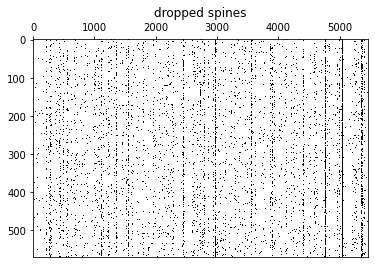

Matrix Shape
(395, 5419)


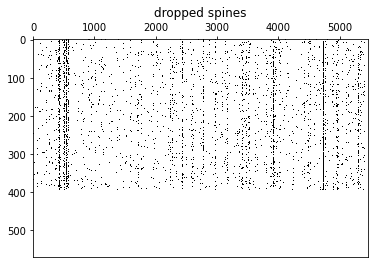

In [50]:
#find duplicates
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

data_M = X.todense()
data_df = pd.DataFrame(data_M, columns=vectorizer.get_feature_names())

# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine = (cosine_similarity(data_df, data_df))

dupli = []
del_list = []
for i in range(len(cosine)):
    for j in range(i+1,len(cosine)):
        if (cosine[i,j]) > 0.65:
            dupli.append(i)
            #dupli.append(str(i)+" - "+str(j))
            if len(data[i]) > len(data[j]):
                if j not in del_list:
                    del_list.append(j)
            elif i not in del_list:
                del_list.append(i)
del_list.sort(reverse = True)
if(DEBUG):
    print("List of Duplicate Documents")
    print(del_list)
    print("/////////")                
    print(len(dupli))
    print(dupli)

original_doc_count = data_df.shape[0]
original_word_count = data_df.shape[1]
print(original_doc_count)
print(original_word_count)
#draw Adj Matrix before duplicate removal
ADJ_MATRIX = True
if (ADJ_MATRIX): 
    draw_adj_matrix(data)
    
# delete dublicates 
for i in range(len(del_list)):
    del data[del_list[i]]
    del year[del_list[i]]

if(WRITE):
    df_document_list = pd.DataFrame(data,columns=['document'])
    df_document_list.to_csv (r'D:/CTA/docs/After Outlier Elimination.csv', index = True, header=True)

#draw Adj Matrix after duplicate removal

if (ADJ_MATRIX): 
    draw_adj_matrix(data)

In [51]:
# context based text edit

#Primary school (if> 6 years)	(Elementaryeducation)
#age: 6	Elementaryeducation
#age: 7	Elementaryeducation
#age: 8	Elementaryeducation
#age: 9	Elementaryeducation
#age: 10	Elementaryeducation
#age: 11, middleschool
#age: 12	middleschool
#age: 13	middleschool
#age: 14	HighSchool
#age: 15	HighSchool
#age: 16	HighSchool
#age: 17	HighSchool

if (True):
    dict1 = {
        
        # tipos or possible mistakes
        "programing" : "programming",
        "/" : " / ",
        ";" : " ; ",
        ":" : " : ",
        "abstract only" : "",
        
        "repetitive pattern" : "loop ",
        
        #Education Level
        "early childhood" : " earlychildhood ",
        "early ages" : " earlychildhood ",
        "kindergarten" : " earlychildhood ",
        "kindergartener" : " earlychildhood ",
        "under 6 years old" : " earlychildhood ",
        "preschool" : " earlychildhood ",
        "pre school" : " earlychildhood ",
        "pre-school" : " earlychildhood ",
        'kid' : ' child ',
        "children" : " child",
        "primary-school" : " earlychildhood ",
        "primary school" : " earlychildhood ",
        "primary education" : " earlychildhood ",
        "primary grade" : " earlychildhood ",
        
        "first grade" : " elementaryeducation ",
        "second grade" : " elementaryeducation ",
        "2nd grade" : " elementaryeducation ",
        "2nd-grade" : " elementaryeducation ",
        "third grade" : " elementaryeducation ",
        "3rd grade" : " elementaryeducation ",
        "3rd-grade" : " elementaryeducation ",
        "4th grade" : " elementaryeducation ",
        "4th-grade" : " elementaryeducation ",
        "fourth grade" : " elementaryeducation ",
        "fourth_grade" : " elementaryeducation ",
        "5th grade" : " elementaryeducation ",
        "5th-grade" : " elementaryeducation ",
        "fifth grade" : " elementaryeducation ",
        "elementary classroom" : " elementaryeducation ",
        "elementary school" : " elementaryeducation ",
        "elementary grade" : " elementaryeducation ",
        "elementary student" : " elementaryeducation student",
        "elementary education" : " elementaryeducation ",
        
        "6th grade" :" middleschool ",
        "6th-grade" :" middleschool ",
        "sixth grade" : " middleschool ",
        "7th grade" :" middleschool ",
        "7th-grade" :" middleschool ",
        "seventh grade" :" middleschool ",
        "8th grade" :" middleschool ",
        "8th-grade" :" middleschool ",
        "eighth garde" :" middleschool ",
        "intermediate grades" :" middleschool ",
        "intermediate education" :" middleschool ",
        "intermediate school" :" middleschool ",
        "middle grade" :" middleschool ",
        "middle school" :" middleschool ",
        "middle schools":" middleschool ",
        
        "undergraduate" : " highereducation ",
        "higher education" : " highereducation ",
        "highereducation" : " highereducation ",
        "postsecondary" : " highereducation ",
        "post secondary" : " highereducation ",
        "post-secondary" : " highereducation ",
        " graduate" : " highereducation ",
        " university" : " highereducation ",
        "college" : " highereducation ",
        "tertiary" : "highereducationin",       
        
        "9th grade" : " highschool ",
        "9th-grade" : " highschool ",
        "ninth grade" : " highschool ",
        "10th garde" : " highschool ",
        "10th-garde" : " highschool ",
        "tenth garde" : " highschool ",
        "11th garde" : " highschool ",
        "11th-garde" : " highschool ",
        "eleventh garde" : " highschool ",
        "12th garde" : " highschool ",
        "12th-garde" : " highschool ",
        "twelfth garde" : " highschool ",
        "high school" : " highschool ",
        "high-school" : " highschool ",
        "high_school" : " highschool ",
        "secondary education" : " highschool ",
        "secondary school" : " highschool ",
        "secondary grade" : " highschool ",
        "k-12" : " ktwelve ",
        "k12" : " ktwelve ",
        
        "problem-solving" : "problemsolving",
        "problem solving" : "problemsolving",
        "solving problems" : "problemsolving",
        "paper-and-pencil" : "paperandpencil",
        "dr. scratch" : "drscratch",
        "open-ended" : "openended",
        "open ended" : "openended",
        #" analytic" : "analytic",
        "data mining" : "datamining",
        "data analytic" : "learninganalytic ",
        "learning analytics" : "learninganalytic ",
        'data analysis' : 'dataanalysis ',
        "hands-on" : "handson ",
        "mixed method" : "mixedmethod ",
        "mixed-method" : "mixedmethod ",
        "pre test" : "pretest ",
        "pre-" : "pretest ",
        "pre-test" : "pretest ",
        "pre_test" : "pretest ",
        "pre questionnaire" : "pretest questionnaire ",
        "pre-questionnaire" : "pretest questionnaire ",
        "pre assessment" : "pretest ",
        "pre survay" : "pretest ",
        "pre-questionnaire" : "pretest questionnaire ",
        "pre-assessment" : "pretest ",
        "pre- " : "pretest ",
        "pre-and" : "pretest ",
        "pre-survay" : "pretest ",
        "post test" : "posttest ",
        "and post-" : "posttest ",
        'pre / post' : "pretest posttest ",
        'pre/post' : "pretest posttest ",
        'pre_post' : "pretest posttest ",
        'pre-post' : "pretest posttest ",
        "post-test" : "posttest ",
        "post_test" : "posttest ",
        "pre post test" : "pretest posttest ",
        "pre post-test" : "pretest posttest ",
        "pre post_test" : "pretest posttest ",
        "pre_post test" : "pretest posttest ",
        "post questionnaire" : "posttest questionnaire ",
        "post assessment" : "posttest ",
        "post survey" : "posttest ",
        "post-questionnaire" : "posttest questionnaire ",
        "post-assessment" : "posttest ",
        "post-survay" : "posttest ",
        "quasi-experimental" : "quasiexperimental ",
        "quasi experimental" : "quasiexperimental ",
        
        "bloom’s taxonomy" : " bloom ",
        "bloom’s model" : " bloom ",
        "bloom's model" : " bloom ",
        "bloom's taxonomy" : " bloom ",
        "bloom_taxonomy" : " bloom ",
        "bloom taxonomy" : " bloom ",
        "bloom-taxonomy" : " bloom ",
        "bloom taxonomy" : " bloom ",
        
        # block-based programming
        "block-based" : " blockbased ",
        "block based" : " blockbased ",
        "block programming" : " blockbased blockprogramming",
        "block-programming" : " blockbased blockprogramming",
        
        "project-based" : "projectbased ",
        "project based" : "projectbased ",
        
        "self efficacy" : "selfefficacy",
        "self-efficacy" : "selfefficacy",
        "self assessment" : "selfassessment",
        "self-evaluation" : "selfassessment",
        "self evaluation" : "selfassessment",
        "self-determination" : "selfassessment",
        "self reported" : "selfreported",
        "self-report" : " selfreported ",
        "self-report" : " selfreported ",
        "self-reportd" : " selfreported ",
        
        "mathematical" : "math ",
        "mathematic" : "math ",
        
        "critical thinking" : "criticalthinking",
        "algorithmic thinking" : " algorithmicthinking ",
        "problem-based learning" : "problembasedlearning",
        "evidence centred" : "evidencecentered",
        "text-based" : "textbased",
        
        # game
        "game-based" : "GameBasedLearning ",
        "game based" : "GameBasedLearning ",
        "educational game" : "GameBasedLearning ",
        "player" : "play",
        'video game' : ' videogame ',
        
        # CT
        "computational thinking" : "ct",
        "computational-thinking" : "ct",
        
        # ct development
        #"development of computational thinking" : "ctdevelopment computational thinking"
        #"development of ct" : "ctdevelopment ct"
        #"computational thinking development" : "computational thinking ctdevelopment"
        #"ct development" : "ct ctdevelopment"
        
        "ct skill" : "ctskill ", #delete #delete #delete #delete #delete #delete #delete #delete
        "ct-skill" : "ctskill ", #delete #delete #delete #delete #delete #delete #delete #delete
        "computational skill" : "ctskill ",
        "cognitive skill" : "cognitive cognitiveskill ",
        "problemsolving skill" : "problemsolving problemsolvingskill ",
        "programming skill" : "programming programmingskill ",
        
        
        "computer science" : "computerscience",
        'creative thinking' : 'creativity',
        'creative-thinking' : 'creativity',
        
        "creative " : "creativity ",
        'creativity-' : 'creativity ',
        "artifact based" : "artifact",
        "artifact-based" : "artifact",
        "app inventor" : "appinventor",
        "app-inventor" : "appinventor",
        "pupil" : "student",
        " learner " : "student",
        
        # Realtime
        " react " : " react realtime",  #???????
        " react. " : " react realtime",  #???????
        " react, " : " react realtime",  #???????
        "real time" : "realtime",
        "real-time" : "realtime",
        
        # Learning Based Algorithms
        'neural network' : "deeplearn ",
        'neural net' : "deeplearn ",
        'neural-network' : "deeplearn ",
        'lstm' : " deeplearn ",
        'lstmbased' : " deeplearn ",
        "deep learning" : "deeplearn ",
        "deep learning model" : "deeplearn ",
        "deep_learning" : "deeplearn ",
        "deep-learning" : "deeplearn ",
        "deep neural network" : "deeplearn ",
        "deep artificial neural network" : "deeplearn ",
        "deepstealth" : " stealth deeplearn ",
        "deep network" : "deeplearn ",
        "machine learning" : "machinelearning",
        "machine-learning" : "machinelearning",
        "topic modelling" : "machinelearning",
        "topic modeling" : "machinelearning",
        "data analysis" : "dataanalysis",
        "factor analysis" : "factoranalysis",
        "motivational" : "motivate",
        "motivation" : "motivate", 
        " cognition" : " cognitive",
        
        #curriculum
        #"programming curricula" : "programming programmingcurriculum ", #programming
        #"programming curriculum" :"programming programmingcurriculum ",
        #"robotics curriculum" : "robotics roboticscurriculum ", #robotics
        #"robotics curricula" : "robotics roboticscurriculum ",
        #" cs curricula" : " cscurriculum ", #computer science
        #" cs curriculum" : " cscurriculum ",
        #" computer science curricula" : " cscurriculum ",
        #" computer science curriculum" : " cscurriculum ",
        #" computerscience curricula" : "computerscience cscurriculum ",
        #" computerscience curriculum" : "computerscience cscurriculum ",
        #"computing curriculum" : " cscurriculum ",
        #"computing curricula" : " cscurriculum ",
        "cross-curricular": "crosscurriculum curriculum", #cross-curricular
        "cross-curricula" : "crosscurriculum curriculum",
        "curricula" : "curriculum ",
        #"school curriculum" : "schoolcurriculum",
        
        
        'academic success' : 'academicsuccess ',
        'academic performance' : 'academicsuccess ', 
        'academic achievement' : 'academicsuccess ',
        'student performance' : 'academicsuccess ',
        "robotics" : "robot",
        "robitic" : "robot",

        'automatic assessment' : 'automatic automaticassessment',
        'automatically' : 'automatic',
        #"noncs_majors"
        #child
        ###################### for proper bigram genearation
        "programming_environments" : "programming programmingenvironment ",
        "programming_environment" : "programming programmingenvironment ",
        'web_development' : "webdevelopment", 
        'learning_scenarios' : 'learningscenarios',
        'programming language' : 'programming programminglanguage',
        'programming languages' : 'programming programminglanguage',
        'fundamental skills' : 'fundamentalskill',
        'fundamental skill' : 'fundamentalskill',
        
        'augmented reality' : 'augmentedreality ',
        'virtual reality' : 'virtualreality ',
        'robot programming' : 'robot robotprogramming programming ',
        'computer scientists' : 'computerscientist ',
        'computational modeling' : 'computationalmodeling ',
        'computational model' : 'computationalmodeling ',
        'software engineering' : 'softwareengineering ',
        'analysis tool' : 'assessmenttool ',
        'testing tool' : 'assessmenttool ',
        'assessment tool' : 'assessmenttool ',
        'assessment instruments' : 'assessmenttool ',
        'assessment instrument' : 'assessmenttool ',
        
        'free play' : 'freeplay play',
        'code analy' : 'codeanalysis ',
        
        'teacher development' : 'teacher_ teacherdevelopment',
        'teacher professional development' : 'teacher_ teacherdevelopment',
        'teacher training' : 'teacher_ teacherdevelopment',
        'teacher professional' : 'teacher_ teacherdevelopment',
        'teacher education' : 'teacher_ teacherdevelopment',
        'teacher understanding' : 'teacher_ teacherdevelopment',
        "teachers' knowledge" : 'teacher_ teacherdevelopment',
        "teacher's knowledge" : 'teacher_ teacherdevelopment',
        'teaching-learning' : 'teacher_ teacherdevelopment',
        'teacher student' : 'teacher_ teacherdevelopment',
        'educator ' : 'teacher_ ',
        'teacher ' : 'teacher_ ',
        'game design' : 'gamedesign',
        'gamedevelopment' : 'gamedesign',
        
        'visual programming' : 'visualprogramming programming',
        'visual languages' : 'visualprogramming',
        'visual language' : 'visualprogramming',
        'graphical programming' : 'visualprogramming programming',
        
        'computer programming' : 'computerprogramming programming',
        
        'computer science education' : 'computerscience computerscienceeducation',
        'computerscience education' : 'computerscience computerscienceeducation',
        'programming profession' : 'programmingprofession',
        
        'backwards design' : 'backwardsdesign',
        
        'game-programming' : 'game programming programming',
        
        #course
        'programming course' : 'programming programmingcourse ',
        "computerscinece course" : "cscourse ",
        "(cs) course" : "cscourse ",
        "cs course" : "cscourse ",
        "computer course" : "cscourse ",
        "(ct) course" : "ctcourse ",
        "ct course" : "ctcourse ",
        "computational thinking course" : "ctcourse ",
        'introductory course' : 'introductory introductorycourse',
        
        
        
        
        'educational technology' : 'educationaltechnology ',
        'educational_technologies' : 'educationaltechnology',
        
        'psychological' : 'psychology',
        'psychometric' : 'psychology',
        
        'statistically' : 'statistic',
        'statistical' : 'statistic',
        'anova' :  'statistic',
        'ttest' :  'statistic',
        'predict ' : 'prediction ',
        'predictive ' : 'prediction ',
        
        'steam' : 'stem',
        'stem' : 'stem ',
        
        'pedagogically' : 'pedagogy',
        'pedagogical' : 'pedagogy',
        'talented' : 'talent ',
        'playing' : 'play',
        'playful' : 'play',
        
        'qualitatively' : 'qualitative',
        'eye tracking' : 'eyetracking',
        'gaze' : 'eyetracking',
        'formatively' : 'formative',
        'project-based' : 'project',
        'log based' : 'log',
        'log-based' : 'log',
        'meta cognitive' : 'cognitive metacognitive',
        'meta-cognitive' : 'cognitive metacognitive',
        'debugging' : 'debug',
        'unplugged' : 'unplug',
        'empirically' : 'empirical',
        "game maker" : "gamemaker",
        "game-maker" : "gamemaker",
        "data structure" : "datastructure",
        
        "mobile application" : " mobile mobileapp ",
        "mobile app" : " mobile mobileapp ",
        "smart phone" : "mobile ",
        "android device " : "mobile ",
        " tablet " : " mobile ",
        
        
        
        "summative" : " summative ",
        'introductory programming course' : 'introductoryprogramming introductorycourse',
        'introductory-programming' : 'introductoryprogramming programming',
        'introductory programming' : 'introductoryprogramming programming',
        'internationally' : 'international' ,
        "learning otucome" : "learningotucome ",
        
        #CT Skills
        "logical thinking" : " logic ", #logic
        "logical-thinking" : " logic ",
        " logical reasoning": " logic ",
        
        "parallelism" : "parallel ", # parallel
        "parallel programming" : "parallel programming",
        "parallelization" : "parallel ",
        
        "synchronizing" : "synchronization ", # synchronization
        "synchronize" : "synchronization ",
        
        "control and data flow" : "ctcontrol and dataflow", #control and # data flow
        "debug, control" : "debug, ctcontrol",
        "flow control" : "dataflow ctcontrol",
        "data flow" : "dataflow ", 
        
        "sequence of" : "",
        "sequences of" : "",
        "sequences" : "ctsequence ",
        "sequencing" : "ctsequence ",
        "sequential problem" : "ctsequence problem",
        "sequential thinking" : "ctsequence ",
        "conditionals" : " conditionalstatement ",
        'conditional statement' : " conditionalstatement ",
        
        #CT dimentions
        "ct concepts, practices and perspectives" : " ctconcept ctpractice ctperspective ", #perspectives, concepts And practices
        "ct concepts, practices, and perspectives" : " ctconcept ctpractice ctperspective ",
        "ctskills and perspective" : "ctskills and ctperspective ",
        "computational thinking skills and perspective" : "ctskills and ctperspective ",
        "practices, and perspectives" : " ctpractice and ctperspective ",
        "practices and perspectives" : " ctpractices and ctperspective ",
        "concepts, practices and computational perspectives" : " ctconcept ctpractice ctperspective ",
        "computational perspective" : "ctperspective ",
        
        "ct concept" : "ctconcept ", #concepts And practices
        "ct practice" : "ctpractice ",
        "computational concept" : "ctconcept",
        "computational practice" : "ctpractice",
     
        
        
        "artificial intelligence" : "artificialintelligence",
        "intelligent" : "intelligent systems",
        "structural equation model" : "structuralequationmodel ",
        
        # web
        'website' : 'web',
        'gamified' : ' gamification ',
        "active learning" : " activelearning ",
        " tracing" : " trace ",
        " traces" : " trace ",
        "natural language processing" : " nlp ",
        "story" : " story ",
        "javascript" : "java",
        "decision" : "decision "
        
        
        
        #['bloom_taxonomy', 'pattern_analysis', 'selfconcept_motivational', ,
         #'logical_thinking', , 'active_learning', 'artificial_intelligence', 
         #'learning_outcomes', 'early_age', 'mathematicematical_problemsolving','computational_practices' ,'computational_concepts', 
         #'curricula_education', 'pattern_recognition', 'programming_course', 'computationalthinking_pattern',
         # 'problemsolving_skills', 'introductory_programming', 
         #'computer_aided', 'computationalthinking_concepts', 'computationalthinking_skills']
        
    
    }
    data = (multiple_replace(dict1, data))

# To lower after context-based text edit
data = [d.lower() for d in data]
if(DEBUG): print (data[0])

#combine phrases with "-" between their words
data = [re.sub("-", "", sent) for sent in data]

if(DEBUG): print(data[30])

570
5462
Matrix Shape
(395, 5786)


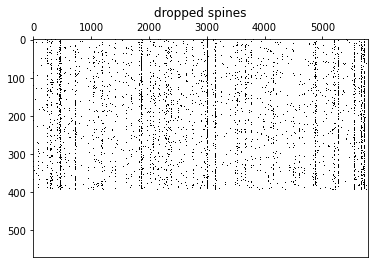

In [52]:
print(original_doc_count)
print(original_word_count)

draw_adj_matrix (data)



In [53]:
#Show bi-grams and 3-grams
min_count = 2
treshold_2grams = 1 
treshold_3grams = 1
bigrams , trigrams = show_ngrams(data, min_count, treshold_2grams, treshold_3grams)
if (CHECK):
    print(bigrams)
    print(trigrams)

In [54]:
data_words = list(sent_to_words(data))
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#pip3 install spacy
#python3 -m spacy download en_core_web_sm
#And then run the following in console.
#nlp = spacy.load("en_core_web_sm")
#doc = nlp("Text here")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

if(DEBUG): print(data_lemmatized[14])

Matrix Shape
(395, 4123)


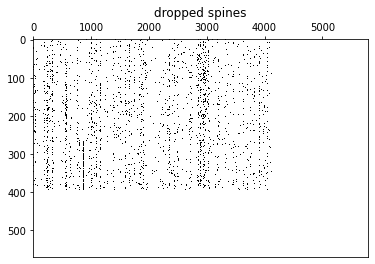

In [55]:
rejoined_docs = []
for item in data_lemmatized:
    words = item
    j = " ".join(words)
    rejoined_docs.append(j)
draw_adj_matrix (rejoined_docs)

# of documents with these keywords: 
4123
                 term  rank
3577          student   316
3957              use   275
1195        education   250
2952      programming   229
3211           result   207
3586            study   205
2136            learn   201
3441            skill   195
254        assessment   179
1017           design   179
1035          develop   177
688   computerscience   174
2681            paper   170
3184         research   151
1038      development   147
2140         learning   147
251            assess   142
917        curriculum   131
2893          present   130
1196      educational   122
3802             tool   116
2944          program   115
3407             show   115
2321          measure   115
169          analysis   114
3692          teacher   112
1349       evaluation   112
830            course   111
3691            teach   111
680          computer   108
698           concept   106
1346         evaluate   105
337              base   104
150   

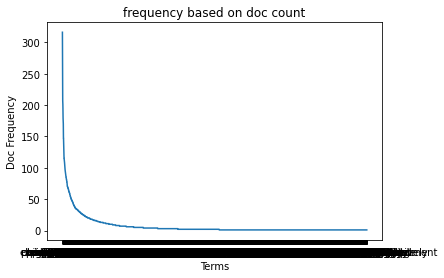

frequency of words in whole dataset: 
4123
                 term  rank
3577          student  1260
2952      programming   810
1195        education   594
3957              use   582
254        assessment   488
3441            skill   463
2136            learn   427
3586            study   395
688   computerscience   379
3692          teacher   344
1017           design   337
830            course   296
3211           result   295
917        curriculum   292
2140         learning   284
1038      development   275
578              code   273
2944          program   253
1035          develop   247
1601             game   243
1196      educational   240
3184         research   233
57           activity   229
251            assess   226
2922     problemsolve   213
1349       evaluation   210
3241            robot   210
3300          scratch   208
3802             tool   206
531             child   204
2681            paper   200
3727             test   192
169          analysis   189
698  

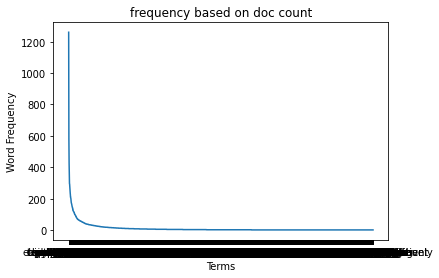

In [56]:
# rejoining tokenozed data to find high tfidf values

def freq_ploting_and_word_list(data):
    rejoined_docs = []
    for item in data:
        words = item
        j = " ".join(words)
        rejoined_docs.append(j)

    #create dtm
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(rejoined_docs)
    terms = vectorizer.get_feature_names()
    binary_sum = np.count_nonzero(X.toarray(), axis=0)
    sums = X.sum(axis=0)

    a = []
    b = []
    for col, term in enumerate(terms):
        a.append( (term, sums[0,col] ))
        b.append( (term, binary_sum[col] ))
    ranking_a = pd.DataFrame(a, columns=['term','rank'])
    ranking_b = pd.DataFrame(b, columns=['term','rank'])
    ranked_terms_freq_based_on_word_count = ranking_a.sort_values('rank', ascending=False)
    ranked_terms_freq_based_on_doc_count = ranking_b.sort_values('rank', ascending=False)
    
    #print the number of documents that include each word of the corpus
    print("# of documents with these keywords: ")
    print(len(ranked_terms_freq_based_on_doc_count))
    #print 50 top words
    print(ranked_terms_freq_based_on_doc_count[0:49])
    simple_plot('frequency based on doc count', 
                (ranked_terms_freq_based_on_doc_count.iloc[: ,0]) , 
                (ranked_terms_freq_based_on_doc_count.iloc[: ,1]), 'Terms', 'Doc Frequency')
    
    #print word frequency in corpus
    print("frequency of words in whole dataset: ")
    print(len(ranked_terms_freq_based_on_word_count))
    #print 50 top words
    print(ranked_terms_freq_based_on_word_count[0:49])
    simple_plot('frequency based on doc count', 
                (ranked_terms_freq_based_on_word_count.iloc[: ,0]) , 
                (ranked_terms_freq_based_on_word_count.iloc[: ,1]), 'Terms', 'Word Frequency')
    
    ranked_terms_freq = ranked_terms_freq_based_on_doc_count
    return ranked_terms_freq

#### delete words that appeared in less than two documents
ranked_terms_freq = freq_ploting_and_word_list(data_lemmatized)
del_list_for_words_repeated_in_less_than_two_docs = list()
for i in range(len(ranked_terms_freq)):
    if ranked_terms_freq.iloc[i]['rank'] <2:
        del_list_for_words_repeated_in_less_than_two_docs.append(ranked_terms_freq.iloc[i]['term'])
if (DEBUG):
    print("del_list_for_words_repeated_in_less_than_two_docs:   "+str(len(del_list_for_words_repeated_in_less_than_two_docs)))
    print(del_list_for_words_repeated_in_less_than_two_docs)
del_list = del_list_for_words_repeated_in_less_than_two_docs
data_lemmatized = [[word for word in doc if word not in del_list] for doc in data_lemmatized]

#### (OPTIONAL!) delete abrevations except the keep_list (find the keep list with the following 3lines of code)
'''for w in terms:
    if len(w) < 4:
        print(w)'''
keep_list_three_letter_abrivations = (['app','art','boy','bug','job','lab','log','toy','web'])
data_lemmatized = [[word for word in doc if (len(word) > 3  or word in keep_list_three_letter_abrivations)] for doc in data_lemmatized]

In [57]:
#### replace some phrases based on manual analysis of remaining words
replace_dict = {
    "blockbased" : "blockbase",
    "blockbaseprogramming" : "blockbase",
    "freshman" : "highereducation",
    "curriculumr" : "curriculum",
    "predictionor" : "prediction ",
    "predictione" : "prediction ",
    "predictionion" : "prediction ",
    "predictionive" : "prediction ",
    "constructionist" : "constructivism",
    'constructionism' : 'constructivism',
    "personalized" : "personalize",
    "personalise" : "personalize",
    'personalisation' : "personalize", 
    'personalized' : "personalize",
    "robotic" : "robot",
    "quantitatively" : "quantitative",
    "systematically" : "systematic", 
    'behavioral' : "behavior",
    'behaviour' : "behavior",
    'innovation' : 'innovative',
    'visualprogramme' : 'visualprogramming',
    'robotprogramme': 'robotprogramming',
    'experimentation' : 'experiment',
    'experimental' : 'experiment',
    'quasiexperimental' : 'experiment',
    'automatically' : 'automatic',
    "logical" : "logic",
    #ct concept
    "ctsequence" : "ct_sequence ctconcept ",  
    "repetitive" : "ct_loop ctconcept ",
    "loop" : "ct_loop ctconcept ",
    "parallelism" : "ct_parallelization ctconcept ",
    "parallel " : "ct_parallelization ctconcept ",
    "conditionalstatement" : "ct_conditional_statement ctconcept ",
    "operators" : "ct_operator ctconcept ",
    "operator" : "ct_operator ctconcept ",
    #ct practices
    "incremental" : "ct_incremental ctpractice ",
    "debug" : "ct_debug ctpractice ",
    "remixe" : "ct_remix ctpractice ",
    "abstractconcept" : "ct_abstraction ctpractice ",
    "abstraction" : "ct_abstraction ctpractice ",
    "module" : "ct_module_ ctpractice ",
    
    "formulating" : "formulation",
    "formulate" : "formulation",
    "formulation" : "formulation",
    
    "nationwide" : "summative",
    "decompositional" : "decomposition",
    "decompose" : "decomposition",
    #"robotscurriculum" : "roboticscurriculum",
    'globally' : 'global',
    'algorithmicthinking' : 'algorithmicthinke',
    'introductoryprogramming' : 'introductoryprogramme',
    'engineer ' : "engineering ",
    'teamwork' : "team",
    "scaffolding" : "scaffold",
    "problemsolve " : "problemsolving ",
    "gamebasedlearning" : "gamebasedlearne",
    "computerprogramming" : "computerprogramme",
    "automate" : "automatic",
    "evidencecentere " : "evidencecentered ",
    "evidencebase":  "evidencecentered",
    "computationalmodele" : "computationalmodeling",
    " brain " : " mental ",
    "intelligent" : "intelligence",
    "structuralequationmodel" : 'structuralequationmodeling',
    "psychologys " : "psychology ",
    "eyetracke" : "eyetracking",
    "machinelearne" : 'machinelearning',
    "classify" : "classification",
    "computerbased" : "computerbase",
    "criticalthinking" : "criticalthinke",
    "experimental":"experiment",
    "modelling":"modeling",
    " cluster " : " clustering ",
    " problemsolving " : " problemsolve ",
    
    "cooperativity" : "cooperative",
    "cooperation" : "cooperative",
    "laboratory " : "lab ",
    "humanrobot" : "robot",
    " analytic " : " learninganalytic ",
    "neopiagetian" : "neopiagetian cognitive",
    "extracurricular" : "afterschool",
    "extracurriculum" : "afterschool",
    "summer" : "afterschool",
    
    "selfregulate": "selfregulation",
    "problembasedlearne" : "problemsolving",
    "realworld":"real_life",
    "communicate" : "communication",
    "women": "girl",
    "likert" : "questionnaire",
    "artefact" : "artifact",
    "smartphone" : "mobile",
    "ipad" : "mobile",
    "emotional" : "emotion",
    "affective" : "emotion",
    "webbase" : "web",
    "forum" : "web",
    "moodle" : "web",
    #"self" : "self self",
    "animated" : "animation",
    "vpython" : "python",
    "postt" : "posttest",
    'post' : 'posttest',
    "multidisciplinary": "interdisciplinary", 
    "blockprogramme" : "blockprogramming",
    "childhood" : "child",
    "childrobot" : "child robot",
    " cognition" : " cognitive",
    "gamemake" : 'gamemaker',
    "cyberplayce" : "internet",
    'engagement': 'engage',
    'motivated' : 'motivate',
    #'team' : 'group',
    'stemdriven': 'stem',
    "gaming" : "game",
    "ctblock" : "blockbase"   
}


#Word replace
rejoined_docs = []
for item in data_lemmatized:
    words = item
    j = " ".join(words)
    rejoined_docs.append(j)

rejoined_docs = (multiple_replace(replace_dict, rejoined_docs))    
data_lemmatized = list(sent_to_words(rejoined_docs))

In [58]:
save_last_data = data_lemmatized

tfidf:  1976
               term       rank
1730        student  29.437305
1417    programming  23.559362
132      assessment  17.171167
580       education  16.359277
1656          skill  15.377725
...             ...        ...
1845  traditionally   0.113872
1720         stream   0.110443
20         accuracy   0.102715
205           brain   0.102561
752     finegrained   0.094773

[1976 rows x 2 columns]
# of all courpus words: 1976

New selected words in this iteration (Number of selected top keywords = 1 ):
robot, gamebasedlearne, game, teacher, mobile, collaborative, rubric, creativity, appinventor, science, highschool, assessmenttool, test, kodu, videogame, gamedesign, unplug, course, collaboration, programming, reliability, assessment, component, selfconcept, cognitive, metric, deeplearn, adaptive, bebra, logic, scratch, ability, program, teacherdevelopment, academicsuccess, framework, software, simulation, english, datamine, math, code, highereducation, process, eyetracking, cu

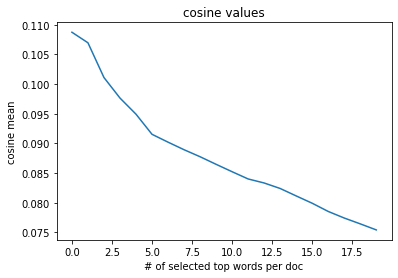

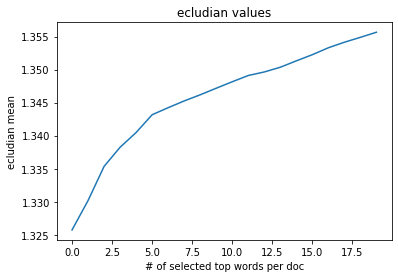

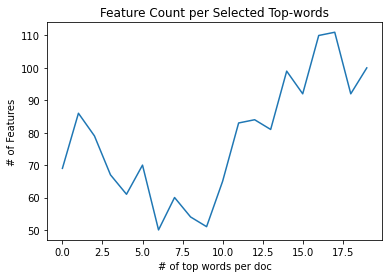

In [59]:
rejoined_docs = []
for item in data_lemmatized:
    words = item
    j = " ".join(words)
    rejoined_docs.append(j)
    
#tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rejoined_docs)
terms = vectorizer.get_feature_names()
sums = X.sum(axis=0)
a = []
for col, term in enumerate(terms):
    a.append((term, sums[0,col] ))
    
ranking = pd.DataFrame(a, columns=['term','rank'])
ranked_terms_tfidf = (ranking.sort_values('rank', ascending=False))
print("tfidf:  " + str(len(ranked_terms_tfidf)))
print(ranked_terms_tfidf)

if (PLOTING):
    simple_plot("tfidf", ranked_terms_tfidf.iloc[: ,0], ranked_terms_tfidf.iloc[: ,1], 'words', 'values')


doc_term_matrix = X.todense()
dtm_df = pd.DataFrame(doc_term_matrix, columns=vectorizer.get_feature_names())
tdm_df = dtm_df.T
print("# of all courpus words: " + str(len(tdm_df)))


from operator import itemgetter
from collections import Counter

total_words = []
total_words_per_iter = []
word_count_per_iter = []
count = []
temp_data = data_lemmatized
cosine_values = []
ecludian_values = []
jaccard_values = []
#Checked the figure for selected keywords per N number of topwords from each document &
#manually checked the selected keywords for different values for top words from 1 to 40
#RESULT: select 7 topwords from each document and apply some exceptions

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
#from sklearn.metrics import jaccard_similarity_score


for i in range(20):  
    temp_data = data_lemmatized
    new_words_with_repeatition = []
    N = i+1
    for doc in X:
        doc_d = doc.tocoo()
        doc_dictionary  = {k:v for k,v in zip(doc_d.col, doc_d.data)}
        sorted_doc_words = sorted(doc_dictionary.items(), key = itemgetter(1), reverse = True)[:N]
        for i in range(len(sorted_doc_words)):
            w = terms[sorted_doc_words[i][0]]
            if w not in total_words:
                new_words_with_repeatition.append(w)

    #word_count_per_iter.append(len(set(new_words_with_repeatition)))
    count.append(i)
    
    print("\nNew selected words in this iteration (Number of selected top keywords = " + str(N) + " ):")
    counts = Counter(new_words_with_repeatition)
    counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    counts_df = counts_df.rename(columns={'index':'word_id', 0:'count'})

    #print new words and update total_words
    iter_words = []
    for i in range(len(counts_df)):
        c = counts_df.iloc[i]['count']
        w = counts_df.iloc[i]['word_id']
        if c > 1:
            if w not in total_words:
                total_words.append(w)
                print(w, end= ', ')
                iter_words.append(w)
                               
    total_words_per_iter.append(iter_words)
    word_count_per_iter.append((len(iter_words)))
                
    temp_data = [[word for word in doc if word in total_words] for doc in temp_data]
    rejoined_docs = []
    for item in temp_data:
        words = item
        j = " ".join(words)
        rejoined_docs.append(j)

    vectorizer = TfidfVectorizer()
    X2 = vectorizer.fit_transform(rejoined_docs)
    doc_term_matrix = X2.todense()
    dtm_df = pd.DataFrame(doc_term_matrix, columns=vectorizer.get_feature_names())
    print("shape" + str(dtm_df.shape))
    # Compute Cosine Similarity
    cosine = (cosine_similarity(dtm_df, dtm_df))
    cosine_mean = (cosine.sum()-len(cosine)) / (len(cosine)*len(cosine))
    print("cosine_sum:  " + str(cosine_mean))
    print(len(cosine))
    
    ecludian = euclidean_distances(dtm_df, dtm_df)
    ecludian_mean = (ecludian.sum()) / (len(ecludian)*len(ecludian))
    print("ecludian_sum:  " + str(ecludian_mean))
    print(len(ecludian))
    
    #jaccard = jaccard_similarity_score(np.array(dtm_df), np.array(dtm_df))
    #jaccard_mean = (jaccard.sum()-(len(jaccard))) / (len(jaccard)*len(jaccard))
    #print("jaccard_sum:  " + str(jaccard_mean))
    #print(len(jaccard))
    
    cosine_values.append(cosine_mean)
    ecludian_values.append(ecludian_mean)
    #jaccard_values.append(jaccard_mean)
    
    
    new_words = []
    new_words_with_repeatition = []

simple_plot("cosine values", count, cosine_values, "# of selected top words per doc", "cosine mean")
simple_plot("ecludian values", count, ecludian_values, "# of selected top words per doc", "ecludian mean")
#simple_plot("jaccard values", count, jaccard_values, "# of selected top words per doc", "jaccard mean")
simple_plot('Feature Count per Selected Top-words', count, word_count_per_iter, '# of top words per doc', '# of Features')



In [60]:
if(CHECK):
    for t in terms:
        if t not in total_words:
            print(t)

In [61]:
if(CHECK): print(ranked_terms_tfidf[0:49])


In [62]:
#'bayes', 'bayesian'
keep_list_from_low_tfidf_words = (["ct_sequence","ct_loop","ct_parallelization ","ct_conditional_statement","ct_operator","ct_incremental","ct_debug",
                                   "ct_remix","ct_abstraction","ct_module_", 'personality', 
                                   'selfassessment', 'synchronization', 'database', 'art', 'computerbase','openende',
                                   'programminglanguage','informal','competition','selfreporte','mental','hand','fullbody','modality',
                                   'selfdirecte','cognitiveskill','bug','studentcreate','studentdesigne', 'discipline' , 'application' , 'expert' , 
                                   'novice' , 'instructor' , 'data' , 'internet' , 'grade' , 'retention' , 'statistic' , 'algorithmic' , 
                                   'selfregulation', "real_life", "mixedmethod","virtualreality", 
                                   "formulation", "reflection", "crosscurriculum", "ethical", "ctcontrol", "ctperspective", 
                                   "innovative", "ctsequence", "generalization", "educationaltechnology", "dataflow", "animation", "formulation",
                                   "inservice", 'fundamentalskill','gamemaker','technologyenhance','posttest', 'nonstem', 'experience',
                                   'mentor','dataanalysis','intellectual','analytical','communication',
                                   'textbase','kodetu','toy','decomposition', 'blockprogramming', 'summative', 'criticalthinke',
                                   'decision', 'neopiagetian', 'structuralequationmodeling', 'algorithmic', 'school', 'programme', 'camp', 
                                   'cyberlearne', 'algorithmicthinke', 'introductoryprogramme', 'snap', 'java', 'secondary', 'planning',
                                   'programmingskill', 'trace', 'experiment', 'gamification', 'architecture', 'programmer', 'teenager',
                                   'pedagogy', 'solve', 'assignment', 'achievement', 'group', 'codeanalysis', 'delphi', 'computerscientist', 'exam',
                                   'handson', 'academic', 'develop', 'multidisciplinary', 'predict', 'behavior', 'realtime', 'ctcourse', 'statistic',
                                   'classification', 'moderate', 'sequence', 'peer', 'interdisciplinary', 'theory', ])

del_list_unrelevant_top_words = (['test', ' assessment', 'component', 'english', 'process', 'trajectory', 'service', 'general', 'scenario', 'environment'
                                  'comprehensive', 'element', 'difficulty', 'educational', 'embody', 'belief', 'variable', 'function', 'embodiment', 
                                  'tree', 'first', 'initiative', 'maker', 'assess', 'convergent', 'chinese', 'objective', 'approach', 'relationship', 
                                  'major', 'influence', 'unit', 'concept', 'principle', 'submission', 'degree', 'item', 'italian', 'inquiry','equity',
                                  'disposition', 'divergence', 'comprehension', 'intention', 'evaluation', 'standard', 'stage', 'background', 
                                  'african', 'primary', 'multiple', 'holistic', 'measure', 'proposal', 'development', 'dissect', 'contest', 'drive', 
                                  'venvi', 'fundamental', 'agile', 'example', 'interest', 'ctpa', 'factor', 'atic', 'write', 'shape', 'effectiveness',
                                  'resource', 'difference', 'include', 'favor', 'impact', 'year', 'basic', 'core', 'board', 'spectrum', 'relation', 
                                  'thinker', 'build', 'acquisition', 'examination', 'user', 'make', 'life', 'support', 'medium', 'subject', 'week', 
                                  'measurement', 'developmentally', 'participant', 'complex', 'change', 'conceptual', 'research', 'value', 'testing', 
                                  'ctsim', 'improve', 'panel', 'environment'])

del_list_based_on_high_frequent = (['student','programming','education','assessment','skill','learn','learning','task'])
del_list_based_on_topic_results = (['language', 'computer', 'computational', 'tool', 'model', 'computing', 'instructional', 'program', 
                                    'system', 'practice', 'control', 'public', 'moderate', 'nonstem', 'gamemaker', 'instruction'])

#deleted from keep list: "dropout",'elearning','ctblock','metacognitive','blockly','thinkaloud', "vocational", 'sensor','multimedia', 'ctsim', 
#'simulate', "noncognitive", 'studentcentere', 'quasiexperiment', 
#delete and replace: 'networking', 'instruction'
#deleted not replaced: 'connectivism','constructivism'


#keep_list_extra = ['administration', 'adult', 'affective',  'blockpy', 'designing', 'diagnostic', 'engage', 'enjoyment', 'extraction', 'formal', 'free',
#          'fun', 'ink', 'institution', 'integral', 'interest', 'interestdriven', 'interpret', 'journal', 'largescale',  'liberal', 'longterm',
#          'measured', 'memory', 'ministry', 'modelling', 'monitor', 'multivariate', 'team', 'networking', 'nlp', 'novel', 'observation', 'papert', 
#                   'quantitative', 'researchbase', 'scoring']

top_keywords  = []
for i in range(5):
    w_list = total_words_per_iter[i]
    top_keywords = top_keywords + w_list


del_list_low_tfidf = []
del_list_low_tfidf = [w for w in terms if ((w not in top_keywords) and (w not in keep_list_from_low_tfidf_words))]
#print(del_list_low_tfidf)
del_list = del_list_unrelevant_top_words + del_list_low_tfidf
del_list += del_list_based_on_high_frequent
del_list += del_list_based_on_topic_results
print(len(del_list_low_tfidf))
print(len(del_list))
#print(del_list)

data_lemmatized = [[word for word in doc if word not in del_list] for doc in data_lemmatized]



1517
1644


Matrix Shape
(395, 335)


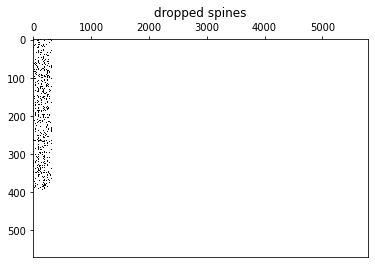

tfidf:  335
Frequency:  335


In [63]:
rejoined_docs = []
for item in data_lemmatized:
    words = item
    j = " ".join(words)
    rejoined_docs.append(j)
draw_adj_matrix (rejoined_docs)

#tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rejoined_docs)
terms = vectorizer.get_feature_names()
sums = X.sum(axis=0)
a = []
for col, term in enumerate(terms):
    a.append((term, sums[0,col] ))
    
ranking = pd.DataFrame(a, columns=['term','rank'])
ranked_terms_tfidf = (ranking.sort_values('rank', ascending=False))
#print("tfidf:  " + str(len(ranked_terms_tfidf)))

#create dtm
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(rejoined_docs)
terms = vectorizer.get_feature_names()
sums = X.sum(axis=0)
a = []
for col, term in enumerate(terms):
    a.append( (term, sums[0,col] ))   
ranking = pd.DataFrame(a, columns=['term','rank'])
ranked_terms_freq = ranking.sort_values('rank', ascending=False)

print("tfidf:  " + str(len(ranked_terms_tfidf)))
if (CHECK): print(ranked_terms_tfidf[0:49])
print("Frequency:  " + str(len(ranked_terms_freq)))
if (CHECK): print(ranked_terms_freq[0:49])


In [64]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

#Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Create the TF-IDF model
tfidf_model = TfidfModel(corpus, smartirs='ntc')
tfidf_vector = tfidf_model[corpus]


topic number = 1
Coherence Score:  0.24714738182246596

topic number = 2
Coherence Score:  0.35367986472151214

topic number = 3
Coherence Score:  0.3608116198468016

topic number = 4
Coherence Score:  0.3750739960161238

topic number = 5
Coherence Score:  0.39451597098186253


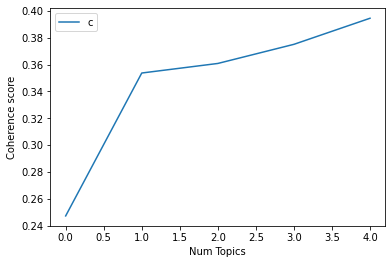

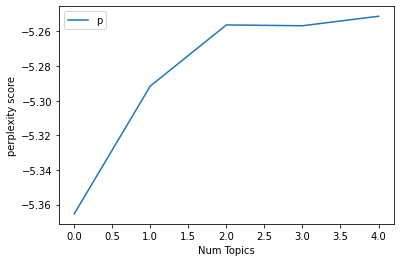

In [65]:
#find Optimal number of topics (Also use the 4 metrics in the R library to find the optimal number of topics)
perplexity = []
coherence = []
x = []
for i in range(5):
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i+1, 
                                               random_state=11,
                                               update_every=1,
                                               chunksize=10,
                                               passes=30,
                                               alpha= 0.5, #(i*0.05), #'auto',
                                                eta = 0.95, #(i*0.05), #0.05,
                                               per_word_topics=True)

    # Set up log to external log file
    import logging
    logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    print("\ntopic number = " +str(i+1))
    #print("\nAlpha = " +str(i*0.1))
    #print("\nBeta = " +str(i*0.1))
    
    #print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    perplexity.append(lda_model.log_perplexity(corpus))
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)
    print('Coherence Score: ', coherence_lda)
    x.append(i)
    
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.plot(x, perplexity)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [66]:
#Data for R to select number of topics // 
'''data_string = ""
for item in data_lemmatized:
    
    data_string += str("@")
    data_string += str(item)
print(data_string)'''

#check documents with less than n words
'''n = 8
for item in data_lemmatized:
    item_set = set(item)
    if len(item_set) < n:      
        print(item_set)'''
    

'n = 8\nfor item in data_lemmatized:\n    item_set = set(item)\n    if len(item_set) < n:      \n        print(item_set)'

In [88]:
# Build LDA model
topic_number = 11
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic_number, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=10,
                                           passes=30,
                                           alpha= 0.15, #'auto', #0.6, 44
                                             eta = 0.4,
                                           per_word_topics=False)

# Set up log to external log file
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [89]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.226939111246759

Coherence Score:  0.36856432100027264


In [90]:

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis
#pyLDAvis.show(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.187156 -0.186214       1        1  18.197462
0      0.364366 -0.078707       2        1  13.597748
5      0.271431  0.081549       3        1  12.866573
2      0.163887  0.348616       4        1   9.159306
9      0.056684 -0.356586       5        1   8.218569
6     -0.332334 -0.098005       6        1   7.882010
10    -0.178809 -0.324550       7        1   7.701243
1     -0.287322  0.127771       8        1   6.980645
3     -0.172294  0.333559       9        1   6.272023
7      0.032808  0.183410      10        1   5.715228
8     -0.105572 -0.030843      11        1   3.409196, topic_info=               Term        Freq       Total Category  logprob  loglift
69          teacher  254.000000  254.000000  Default  30.0000  30.0000
20             game  198.000000  198.000000  Default  29.0000  29.0000
10            robot  267.000000  267.000000  Default  28.0000  28.0000
113         scratch  209.000000  209.000000  Default  27.0000  27.0000
112  problemsolving  225.000000  225.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
44         scaffold    1.493031   25.422194  Topic11  -5.8421   0.5439
268            snap    0.694305    9.498031  Topic11  -6.6077   0.7628
33     architecture    1.008136   18.955975  Topic11  -6.2348   0.4447
103       interview    1.548345   51.596279  Topic11  -5.8057  -0.1276
31            teach    1.226547  168.218979  Topic11  -6.0387  -1.5424

[466 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
49        1  0.763236    ability
49        2  0.193496    ability
49        3  0.010750    ability
49       10  0.010750    ability
49       11  0.010750    ability
...     ...       ...        ...
116       4  0.046980      young
121       3  0.114246      youth
121       9  0.571230      youth
310       8  0.662125  zoombinis
310      10  0.094589  zoombinis

[1143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 3, 10, 7, 11, 2, 4, 8, 9])

In [91]:
if(CHECK):
    # Print top keywords of the topics
    pprint(lda_model.print_topics())

    
    #print lda_model data
    doc_lda = lda_model[corpus]
    i = 0
    for row in doc_lda:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        i += 1
        print("Doc #" + str(i) + " :")
        print(row)

#for mallet
#print(ldamallet[corpus])
#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=30))

In [92]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data) #ldamodel=optimal_model

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
if (WRITE): df_dominant_topic.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/document-topic-association.csv', index = False, header=True)

In [93]:
rejoined_docs = []
for item in data_lemmatized:
    words = item
    j = " ".join(words)
    rejoined_docs.append(j)

#tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rejoined_docs)

doc_term_matrix = X.todense()
dtm_df = pd.DataFrame(doc_term_matrix, columns=vectorizer.get_feature_names())

### cosine for documents
cosine_doc = (cosine_similarity(doc_term_matrix, doc_term_matrix))

doc1 = []
doc2 = []
value = []
d = 0
s = 0
for i in range(len(cosine_doc)):
    for j in range(len(cosine_doc)):
        if cosine_doc[i][j] > 0:
            doc1.append(i+1)
            doc2.append(j+1)
            if (cosine_doc[i][j] < 0.09):
                value.append(0)
            else:
                value.append(cosine_doc[i][j])
            d += 1
            s += cosine_doc[i][j]
            
            
print("s:   "+str(s/((len(cosine_doc)*len(cosine_doc)))))
n= len(cosine_doc)
m=n+1
df_doc = pd.DataFrame({str(m): doc1, str(n): doc2 , str(d):value})
if (WRITE): df_doc.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/doc_doc_adj.csv', index = False, header=True)

temp_topics = []
for item in df_dominant_topic['Dominant_Topic']:
    temp_topics.append(item)
temp_topics = temp_topics[0:395]
#print(len(year))
#print(len(temp_topics))
#print(temp_topics)
df_topic_docs = pd.DataFrame({'Dominant_Topic': temp_topics, 'Year': year})
#print(df_topic_docs)
#df_topic_docs = pd.concat([temp_df_topic, temp_df_year], axis=1)
if (WRITE): df_topic_docs.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/doc_topic_association.csv', index = False, header=True)
     
for i in range(len(year)): 
    if year[i] == "":
        year[i] = 2022
    if "{" in str(year[i]):
        y = year[i]
        year[i] = y[1:5]
    year[i] = int(year[i])

#print(year)    

year_categories = []
topic_categories = []
year_zeros = []
for i in range(17):
    year_categories.append(str(2006+i))
    year_zeros.append(0)
    
for i in range(11):
    topic_categories.append(i+1)
    
trend = np.zeros((len(year_categories), len(topic_categories)))
df_topic_year_stacked=pd.DataFrame({"0":year_zeros,
                                    "1":year_zeros,
                                    "2":year_zeros,
                                    "3":year_zeros,
                                    "4":year_zeros,
                                    "5":year_zeros,
                                    "6":year_zeros,
                                    "7":year_zeros,
                                    "8":year_zeros,
                                    "9":year_zeros,
                                    "10":year_zeros})

df_topic_year_stacked.index = year_categories
for i in range(len(year)):
    d = df_topic_year_stacked.loc[str(year[i]) , str(int(temp_topics[i]))]
    d = d+1
    df_topic_year_stacked.at[str(year[i]) , str(int(temp_topics[i]))] = d
    
if (WRITE): df_topic_year_stacked.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/df_topic_year_stacked.csv', index = True, header=True)
    

########## make network nodes csv ########################################

# get the list of top words and their scores in the topics

word_list_unique = []
word_score_dict = {}
word_topic_dict = {}
for i in range(topic_number):
    
    #temp_topic = optimal_model.print_topics(num_words=5)[i][1]
    temp_topic = lda_model.print_topics(num_words=30)[i][1]
    temp_list = temp_topic.split(" + ")
    temp_list = [x[:-1] for x in temp_list]
    for t in temp_list:
        w = t.split('*"')
        if str(w[1]) not in word_list_unique:
            word_score_dict [str(w[1])]=[float(w[0])]
            word_topic_dict [str(w[1])]=[i+1]
            word_list_unique.append(str(w[1]))
        elif word_topic_dict [str(w[1])] < [float(w[0])]:
            word_score_dict [str(w[1])]=[float(w[0])]
            word_topic_dict [str(w[1])]=[i+1]

word_topic = []
word_score = []
for word in word_list_unique:
    word_topic.append(word_topic_dict[word][0])
    word_score.append(word_score_dict[word][0]*2000)

df_nodes = pd.DataFrame({"name": word_list_unique, "group": word_topic , "nodesize":word_score})
if (WRITE): df_nodes.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/nodes.csv', index = False, header=True)

######## make source destination csv ########################### 
        
### cosine for words
tdm_df = dtm_df.T
#print(tdm_df.shape) 

#delete column and row from tdm matrix if a word are not in a top word in a topic
for ind in tdm_df.index:
    if ind not in word_list_unique:
        tdm_df = tdm_df.drop(ind)

# keep the list of words based on tdm matrix indexes
tdm_word_list = []
for ind in tdm_df.index:
    tdm_word_list.append(ind)

#similarity between words
cosine_tdm = (cosine_similarity(tdm_df, tdm_df))

#make source destination csv
w1 = []
w2 = []
sim = []
words = []
source = []
target = []
d = 0
for i in range(len(tdm_word_list)):
    for j in range((i+1),len(tdm_word_list)):
        if cosine_tdm[i][j] > 0.15 and i != j:
            sim.append((cosine_tdm[i][j])*200)
            source.append(tdm_word_list[i])
            target.append(tdm_word_list[j])

df_source_target = pd.DataFrame({"source": source, "target": target , "value":sim})
if (WRITE): df_source_target.to_csv (r'D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/df_source_target.csv', index = False, header=True)


#for i in range(len(tdm_df)):
#    words.append(tdm_df.index[i])
#words_score =[0]*n
#words_topic = [0]*n
#t = 0
#for topic in my_topics:
#    t += 1
#    for i in range(len(words)):
#        #print(type(words_score[i]))
#        #print(type(topic[words[i][0]]))
#        
#        print(t)
#        print(words[i])
#        print(topic[words[i]][0])
#        if (float(words_score[i]) < float(topic[words[i]][0])):
#            words_score[i] = float(topic[words[i]][0])
#            words_topic[i] = t
        
        
#df_adj_topics = pd.DataFrame({"words" : words , "scores": words_topic})
#df_adj_topics.to_csv (r'D:/CTA/cta_adj/adj_topics.csv', index = False, header=True)

#print(words[0])       
#print(my_topics[0][words[0]][0])


s:   0.06877891606497122


In [94]:
#print(df_nodes)

#for i in range(11):
def calculate_source_and_target_topics(num_words):
    word_list_unique = []
    word_score_dict = {}
    word_topic_dict = {}
    topics = []
    topic = ""
    for i in range(topic_number):   
        topic = ""
        temp_topic = lda_model.print_topics(num_words = num_words)[i][1]
        temp_list = temp_topic.split(" + ")
        temp_list = [x[:-1] for x in temp_list]
        for t in temp_list:
            w = t.split('*"')
            topic += " "
            topic += (str(w[1]))
            word_topic_dict [str(w[1])]=[i+1]
        topics.append(topic)
    word_topic = []
    word_score = []

    #print(topics)
    #df_nodes_new = pd.DataFrame({"name": word_list_unique, "group": word_topic , "nodesize":word_score})

    vectorizer = TfidfVectorizer()
    Y = vectorizer.fit_transform(topics)

    topics_M = Y.todense()
    topics_df = pd.DataFrame(topics_M, columns=vectorizer.get_feature_names())

    # Compute Cosine Similarity
    from sklearn.metrics.pairwise import cosine_similarity
    cosine = (cosine_similarity(topics_df, topics_df))
    cosine_copy = (cosine_similarity(topics_df, topics_df))
    #print(cosine)

    list_of_connected_topics = []
    for row in cosine:
        r = row
        r.sort()
        list_of_connected_topics.append([round(r[-2], 4),round(r[-3], 4),round(r[-4], 4)])

    #print(list_of_connected_topics)

    i = 0
    list_of_connected_topics_index = []
    for row in cosine_copy:
        j = 0
        indexes = []
        for r in row:
            j += 1
            if round(r, 4) in list_of_connected_topics[i]:
                indexes.append(j)
        i += 1
        list_of_connected_topics_index.append(indexes)
    #print(list_of_connected_topics_index)   

    source_topic = []
    target_topic = []
    a = list_of_connected_topics_index
    for i in range(len(a)):
        for j in range(len(a[i])):
            #print("new")
            #print(i)
            #print(a[i][j] - 1)
            if i < (a[i][j] - 1) or i+1 not in (a [(a[i][j] - 1)]):
                source_topic.append(str(i+1))
                target_topic.append(str(a[i][j]))
    
    print(str(num_words)+" : " + str(len(source_topic)))
    return source_topic, target_topic


In [95]:
#find optimal number of connections in network
for i in range(10):
    s, t = calculate_source_and_target_topics(i+10)

print("source = c(" + str(s)[1:-1] +")")
print("target = c(" + str(s)[1:-1] +")")

10 : 53
11 : 45
12 : 35
13 : 20
14 : 21
15 : 22
16 : 22
17 : 20
18 : 21
19 : 21
source = c('1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '5', '5', '6', '7', '8', '8', '9', '9', '10', '10')
target = c('1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '5', '5', '6', '7', '8', '8', '9', '9', '10', '10')


In [96]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9178,"robot, earlychild, child, code, ctconcept, gro...",the effects of coding on child s planning and...
1,1.0,0.7701,"game, gamebasedlearne, deeplearn, stealth, sim...",all good things come in threes : assessing st...
2,2.0,0.9479,"scratch, blockbase, project, assessmenttool, l...",software clones in scratch projects : on the ...
3,3.0,0.8337,"creativity, code, automatic, technique, comput...",adoption of computerprogramming programming ex...
4,4.0,0.8871,"course, ctpractice, computerscience, higheredu...",first year academicsuccess in a test for ct ...
5,5.0,0.9150,"curriculum, ktwelve, stem, computerscience, hi...",a nationwide exam as a tool for improving a ne...
6,6.0,0.9520,"framework, problemsolving, cognitive, math, th...",digital ink for cognitive assessment of ct ; ...
7,7.0,0.6610,"instrument, interaction, scale, factoranalysis...",an investigation of the data collection instru...
8,8.0,0.6425,"modeling, computationalmodeling, pattern, prog...",understanding student ct with computationalmod...
9,9.0,0.6593,"teacher, attitude, teaching, lesson, teacherde...",starting from scratch : developing a pretest ...


In [97]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics
topic_num_keywords
#df_dominant_topics

,Dominant_Topic,Topic_Keywords
0,0.0,"robot, earlychild, child, code, ctconcept, gro..."
1,1.0,"game, gamebasedlearne, deeplearn, stealth, sim..."
2,0.0,"robot, earlychild, child, code, ctconcept, gro..."
3,4.0,"course, ctpractice, computerscience, higheredu..."
4,1.0,"game, gamebasedlearne, deeplearn, stealth, sim..."
...,...,...
390,4.0,"course, ctpractice, computerscience, higheredu..."
391,4.0,"course, ctpractice, computerscience, higheredu..."
392,10.0,"science, activity, engineering, classroom, mot..."
393,2.0,"scratch, blockbase, project, assessmenttool, l..."


In [98]:
import networkx as nx
from matplotlib import pyplot, patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="2"))
            current_idx += len(module)

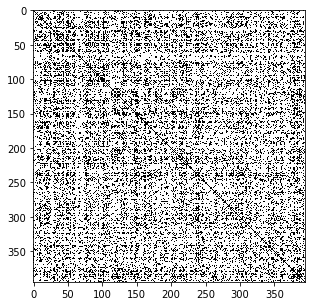

In [99]:
from scipy import io

A = io.mmread("D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/s3rmt3m1.mtx")
G = nx.from_scipy_sparse_matrix(A)
draw_adjacency_matrix(G)

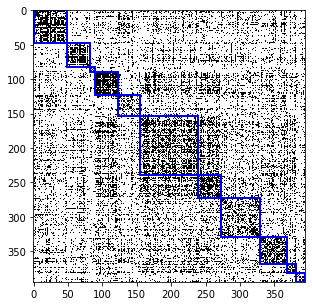

In [100]:


def assignmentArray_to_lists(assignment_array):
    by_attribute_value = defaultdict(list)
    for node_index, attribute_value in enumerate(assignment_array):
        by_attribute_value[attribute_value].append(node_index)
    return by_attribute_value.values()

# Load in array which maps node index to dorm number
# Convert this to a list of lists indicating dorm membership
dorm_assignment = np.genfromtxt("D:/00_ MYT/03_ PAPERS for submission/ECEL_CTA/Code Files/Bubble.txt", dtype="u4")
#dorm_assignment = np.genfromtxt("D:/Bubble.txt")

#data = u"1, 2, 3\n4, 5, 6"
#dorm_assignment = np.genfromtxt(StringIO(data), delimiter=",")
#dorm_assignment = np.genfromtxt(d)
dorm_lists = assignmentArray_to_lists(dorm_assignment)

#print(dorm_assignment)
#print(dorm_lists)
# Create a list of all nodes sorted by dorm, and plot
# adjacency matrix with this ordering
nodes_dorm_ordered = [node for dorm in dorm_lists for node in dorm]
draw_adjacency_matrix(G, nodes_dorm_ordered, [dorm_lists],["BLUE"])